In [1]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, moment
from IPython.display import display



In [2]:
# Import function from our custom module
from mlfinlab.bet_sizing.ef3m import M2N, raw_moment, most_likely_parameters

# Defining help methods
def mixture_samples(params, n=10_000):
    """
    Returns 'n' samples from a mixture distribution defined by 'params'.

    :param params: (list) Mixture parameters [mu1, mu2, sigma1, sigma2, p1].
    :param n: (int) Number of samples to draw.
    :return: (np.array) An array of the length 'n' of distribution mixture samples.
    """

    n1 = int(n*params[4])
    n2 = n - n1
    d1 = np.random.normal(params[0], params[2], n1)
    d2 = np.random.normal(params[1], params[3], n2)

    return np.concatenate((d1, d2))

def plot_fit(true_list, fit_list, n=10_000):
    """
    Plots the true and fit mixture distributions.

    :param true_list: (list) True parameters [mu1, mu2, sigma1, sigma2, p1].
    :param fit_list: (list) True parameters [mu1, mu2, sigma1, sigma2, p1].
    :param n: (int) Number of samples to draw.
    """

    d_true = mixture_samples(true_list, n)
    d_fit = mixture_samples(fit_list, n)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.distplot(d_true, kde=True, bins=200, ax=ax, label=f'True Mixture Distribution {true_list}')
    sns.distplot(d_fit, kde=True, bins=200, ax=ax, label=f'Fitted Mixture Distribution {fit_list}')
    ax.legend(loc='upper left')

    plt.show()

----
### Case 1: Example data from source literature
López de Prado, M. and M. Foreman (2014): "A mixture of Gaussians approach to mathematical portfolio oversight: The EF3M algorithm." _Quantitative Finance_, Vol. 14, No. 5, pp. 913-930. The below cell calculates the raw moments from the sample distribution parameters, $(-2, 1, 2, 1, \frac{1}{10})$, as a demonstration of the helper functions. 

In [3]:
# Moments and parameters from source literature
true_params = [-2, 1, 2, 1, 0.1]

true_samples = mixture_samples(true_params, n=1_000_000)

# Calculate the central moments
mmnts = [moment(true_samples, moment=i) for i in range(1, 6)]

# Calculate the raw moments
raw_mmnts = raw_moment(central_moments=mmnts, dist_mean=np.mean(true_samples))

# Moments caluclated from the paper
moments = [0.7, 2.6, 0.4, 25, -59.8]

# Let's look at the moments
display(pd.DataFrame.from_dict({'Moment': [f'E[r^{i+1}]' for i, m in enumerate(mmnts)],
                                'From paper': moments,
                                'Central (about mean)': mmnts,
                                'Raw (about origin)': raw_mmnts,
                                'Significance': ['Mean', 'Variance', 'Skewness', 'Kurtosis', 'Hyperskewness']}))

,Moment,From paper,Central (about mean),Raw (about origin),Significance
0,E[r^1],0.7,0.000000,0.698523,Mean
1,E[r^2],2.6,2.114952,2.602886,Variance
2,E[r^3],0.4,-4.392067,0.380793,Skewness
3,E[r^4],25.0,30.887555,25.045543,Kurtosis
4,E[r^5],-59.8,-153.908397,-60.085719,Hyperskewness


The cell below executes a number of fits and collects the results into a table of the most likely parameters (using a kernel density estimation), and the average and standard deviation of the difference between the true value and fit values from each fitting run. The cell after this plots the distributions generated from the true and most likely parameters as an ultimate comparison of the fit. It is especially useful in instances where the most likely set of fitted parameters is one of the multiple solutions that does not exactly match the true parameters.

In [9]:
# Keep in mind that 20_000 runs takes approx. 4h30min (Intel i7-7700K)

n_runs = 100
epsilon = 10**-6
factor = 5

m2n = M2N(moments, epsilon=epsilon, factor=factor, n_runs=n_runs, variant=2, max_iter=10_000_000)
df2 = m2n.mp_fit()
df2 = df2.sort_values('error')
results = most_likely_parameters(df2)

# Setup comparison DataFrame
para_cols = ['mu_1', 'mu_2', 'sigma_1', 'sigma_2', 'p_1']

for ei, pcol in enumerate(para_cols):
    df2[pcol+'_err'] = true_params[ei] - df2[pcol]

df_results_case1 = pd.DataFrame.from_dict({'Parameter': ['mu1', 'mu2', 'sigma1', 'sigma2', 'p1'],
                                           'Original': true_params,
                                           'Most Likely': list(results.values()),
                                           'Deviation Average': [df2[col].mean() for col in [p+'_err' for p in para_cols]],
                                           'Deviation StDev': [df2[col].std() for col in [p+'_err' for p in para_cols]]})

display(df_results_case1)

|#########################| Completed 100 of 100 fitting rounds.

,Parameter,Original,Most Likely,Deviation Average,Deviation StDev
0,mu1,-2.0,-1.70165,-0.182784,0.213388
1,mu2,1.0,1.01245,-0.006497,0.009204
2,sigma1,2.0,2.09177,-0.055306,0.065842
3,sigma2,1.0,0.98662,0.009041,0.010064
4,p1,0.1,0.11448,-0.009333,0.010459


/Users/junwei1/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/junwei1/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


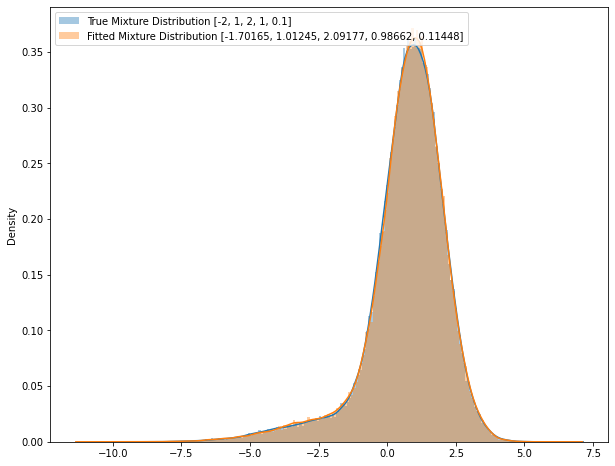

In [10]:
# Plot the distributions generated from the true and most likely parameters
plot_fit(true_params, list(results.values()), n=100_000)

----
### Case 2: User-defined single example
Define the parameters of the two Gaussian distributions to mix in the cell below.

In [11]:
# Setup user sample
mu1 = -1
mu2 = 4
sigma1 = 2
sigma2 = 1.5
p1 = 0.45

In [12]:
# Generate 10_000 samples for our custom mixture distribution
true_params = [mu1, mu2, sigma1, sigma2, p1]
true_samples = mixture_samples(true_params, n=100_000)

# Calculate the central moments
mmnts = [moment(true_samples, moment=i) for i in range(1, 6)]

# Calculate the raw moments
raw_mmnts = raw_moment(central_moments=mmnts, dist_mean=np.mean(true_samples))

# Let's look at the moments
display(pd.DataFrame.from_dict({'Moment':[f'E[r^{i+1}]' for i, m in enumerate(mmnts)],
                                'Central (about mean)': mmnts,
                                'Raw (about origin)': raw_mmnts,
                                'Significance': ['Mean', 'Variance', 'Skewness', 'Kurtosis', 'Hyperskewness']}))

,Moment,Central (about mean),Raw (about origin),Significance
0,E[r^1],0.000000,1.748903,Mean
1,E[r^2],9.124296,12.182957,Variance
2,E[r^3],-9.413620,43.808201,Skewness
3,E[r^4],185.209359,296.159509,Kurtosis
4,E[r^5],-462.148288,1373.934536,Hyperskewness


|#########################| Completed 50 of 50 fitting rounds.

'Top values from the EF3M fit:'

,mu_1,mu_2,sigma_1,sigma_2,p_1,error
0,-0.985520,3.982406,1.991187,1.497238,0.449580,0.000120
0,-0.989203,3.978691,1.990164,1.499582,0.448982,0.001643
0,-0.985381,3.982347,1.991314,1.497307,0.449586,0.000166
0,-0.986172,3.985764,1.989231,1.494462,0.449802,0.000693
0,-0.995349,3.983806,1.983433,1.494514,0.448912,0.013405


,Original,Estimated
0,-1.00,-0.98780
1,4.00,3.98477
2,2.00,1.99030
3,1.50,1.49481
4,0.45,0.44969


/Users/junwei1/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/junwei1/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


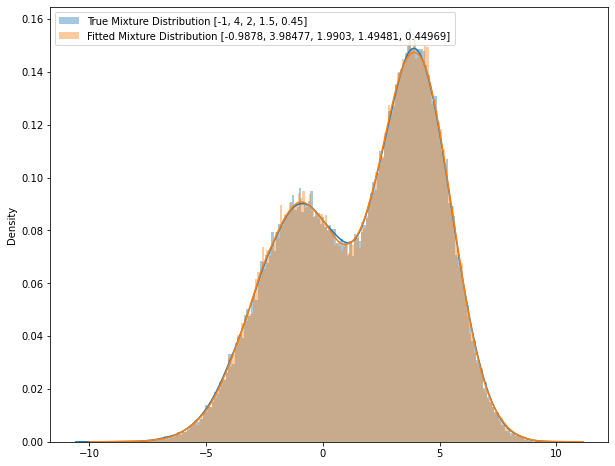

In [14]:
n_runs = 50
epsiolon = 10**-5
factor = 5

m2n = M2N(raw_mmnts, epsilon=epsilon, factor=factor, n_runs=n_runs, variant=2, max_iter=10_000_000)
df_results = m2n.mp_fit()
display("Top values from the EF3M fit:")
display(df_results.head())
results = most_likely_parameters(df_results)
display(pd.DataFrame.from_dict({'Original': true_params,
                                'Estimated': list(results.values())}))

# Adjust 'n' to get a smoother distribution
plot_fit(true_params, list(results.values()), n=100_000)

----
### Case 3: Series of randomly generated examples
In López de Prado and Foreman (2014), the authors used randomly generated Gaussian mixture distributions to test that the EF3M algorithm performed well in general. The parameter tuple desribing the observed distribution, $(\tilde{\mu}_1, \tilde{\mu}_2, \tilde{\sigma}_1, \tilde{\sigma}_2, \tilde{p}_1)$, was drawn from the uniform distribution with boundaries $-1 \leq \mu_1 \leq 0 \leq \mu_2 \leq 1$, $0 < \sigma_1 \leq 1$, $0 < \sigma_2 \leq 1$, $0 < p < 1$. This is reflected in the code below. Change the number of rounds, number of fits per round, and mixture parameters to test additional scenarios. Authors used 10,000 test rounds and 10,000 fits per round, but note that running this on a single developer workstation will take days or weeks to complete, so smaller numbers are advised.

In [15]:
test_rounds = 5  # Number of random tests to conduct
fit_runs = 10  # M2N fitting rouns per round
epsiolon = 10**-5
factor = 5

# Define parameter ranges, (low, high)
mu1_range = (-1, 0)
mu2_range = (0, 1)
sigma1_range = (1e-5, 1)
sigma2_range = (1e-5, 1)
p1_range = (1e-5, 1-1e-5)

param_ranges = [mu1_range, mu2_range, sigma1_range, sigma2_range, p1_range]
true_collection, fit_collection = [], []
mu1_err, mu2_err, sigma1_err, sigma2_err, p1_err = [], [], [], [], []
m1_err, m2_err, m3_err, m4_err, m5_err = [], [], [], [], []

for round_i in range(test_rounds):
    true_params = [np.random.uniform(r[0], r[1]) for r in param_ranges]  # Generate random parameters
    true_samples = mixture_samples(true_params, n=10_000)
    mmnts = [moment(true_samples, moment=i) for i in range(1, 6)]  # Calculate the central moments
    raw_mmnts = raw_moment(central_moments=mmnts, dist_mean=np.mean(true_samples))  # Calculate the raw moments
    m2n = M2N(raw_mmnts, epsilon=epsilon, factor=factor, n_runs=fit_runs, variant=2, max_iter=10_000_000)
    df_results = m2n.mp_fit()
    results = list(most_likely_parameters(df_results).values())
    fit_mmnts = m2n.get_moments(results, return_result=True)
    
    # Store results
    true_collection.append(true_params)
    fit_collection.append(results)
    
    # Store parameter deviations
    for ai, a_err in enumerate([mu1_err, mu2_err, sigma1_err, sigma2_err, p1_err]):
        a_err.append(true_params[ai] - results[ai])
    
    # Store moment deviation
    for bi, m_err in enumerate([m1_err, m2_err, m3_err, m4_err, m5_err]):
        m_err.append(mmnts[bi] - fit_mmnts[bi])
    

df_collection = pd.DataFrame.from_dict({'Original': true_collection,
                                        'Fit': fit_collection,
                                        'mu1_err': mu1_err, 'mu2_err': mu2_err, 'sigma1_err': sigma1_err, 'sigma2_err': sigma2_err, 'p1_err': p1_err,
                                        'm1_err': m1_err, 'm2_err': m2_err, 'm3_err': m3_err, 'm4_err': m4_err, 'm5_err': m5_err})

err_cols = ['mu1_err', 'mu2_err', 'sigma1_err', 'sigma2_err', 'p1_err']
m_cols = ['m1_err', 'm2_err', 'm3_err', 'm4_err', 'm5_err']

df_results_case2 = pd.DataFrame.from_dict({'Errors': [1, 2, 3, 4, 5],
                                           'Errors Average': [df_collection[col].mean() for col in m_cols],
                                           'Errors StDev': [df_collection[col].std() for col in m_cols],
                                           'Deviation': ['mu1', 'mu2', 'sigma1', 'sigma2', 'p1'],
                                           'Deviation Average': [df_collection[col].mean() for col in err_cols],
                                           'Deviation StDev': [df_collection[col].std() for col in err_cols]})

print("Compare results to Figure 4 in López de Prado and Foreman (2014)")

display(df_results_case2)

|#########################| Completed 10 of 10 fitting rounds.

Compare results to Figure 4 in López de Prado and Foreman (2014)


,Errors,Errors Average,Errors StDev,Deviation,Deviation Average,Deviation StDev
0,1,0.003170,0.572401,mu1,0.069305,0.099645
1,2,-0.261504,0.270264,mu2,0.044723,0.074937
2,3,0.112048,0.879190,sigma1,0.010479,0.031624
3,4,-0.421054,0.495137,sigma2,-0.014947,0.066268
4,5,0.657943,3.262775,p1,0.066513,0.103901
